In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import csv

import sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbaPipeline
from joblib import dump, load

import spacy

In [5]:
data = pd.read_csv("cyai.tsv", sep="\t")

In [6]:
nlp = spacy.load("en_core_web_lg")

In [7]:
docs = []
for doc in nlp.pipe(data.description):
    docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [8]:
logistic_hyperparams = {
    "solver": ["liblinear"],
    "C": [0.25, 0.5, 1, 2, 4],
    "penalty": ["l1", "l2"]
}

adaboost_hyperparams = {
    'n_estimators': [8, 32, 128, 512],
    'learning_rate': [0.125, 0.25, 0.5, 1],
}

gradboost_hyperparams = {
    'loss' : ['deviance', 'exponential'],
    'n_estimators': [8, 32, 128, 512],
    'max_depth': [1, 2 , 4, 8]
}

randomforest_hyperparams = {
    'n_estimators': [8, 32, 128, 512],
    'max_depth': [1, 2, 4, 8]
}

decisiontree_hyperparams = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [1, 2 , 4, 8],
}

mlp_hyperparams = {
    "activation": ["tanh", "relu"],
    "alpha": [1e-3, 1e-4, 1e-5],
    "max_iter": [32,128,512],
    "learning_rate": ["constant", "adaptive"],
}

svc_hyperparams = {
    "probability": [True],
}

In [11]:
models_hyperparams = [
    logistic_hyperparams,
    randomforest_hyperparams,
    decisiontree_hyperparams,
]

models = [
    LogisticRegression,
    RandomForestClassifier,
    DecisionTreeClassifier,
]

In [24]:
vectorizer = CountVectorizer(
    max_df = 0.75,
    max_features = None,
    min_df = 2,
)
X = vectorizer.fit_transform(docs)

In [25]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, data.is_ethics)

In [12]:
best_gridsearch = None

In [26]:
n_folds = 4
n_jobs = 7

for Model, hyperparams in zip(models, models_hyperparams):
    parameters = {
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
    }
    for h in hyperparams:
        parameters["clf__{}".format(h)] = hyperparams[h]
    
    pipeline = Pipeline([
        ('tfidf', TfidfTransformer()),
        ('clf', Model()),
    ])
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               scoring="roc_auc",
                               cv=StratifiedKFold(n_folds, shuffle=True),
                               n_jobs=n_jobs,
                               verbose=1)

    grid_search.fit(X_resampled, y_resampled), 
    print(type(grid_search.best_estimator_.named_steps["clf"]).__name__, grid_search.best_score_)
    
    if best_gridsearch is None or grid_search.best_score_ > best_gridsearch.best_score_:
        best_gridsearch = grid_search

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    2.2s
[Parallel(n_jobs=7)]: Done 160 out of 160 | elapsed:    2.4s finished
C:\Users\Pedro\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


LogisticRegression 0.974664733226377
Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done 256 out of 256 | elapsed:   10.2s finished
C:\Users\Pedro\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier 0.9802799374717183
Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done 256 out of 256 | elapsed:    0.7s finished
C:\Users\Pedro\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DecisionTreeClassifier 0.8588202928956354


In [27]:
best_gridsearch.best_params_

{'clf__max_depth': 8,
 'clf__n_estimators': 512,
 'tfidf__norm': 'l1',
 'tfidf__use_idf': False}

In [28]:
best_gridsearch.best_estimator_.named_steps["clf"]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = False,
        )),
        ('clf', RandomForestClassifier(
            max_depth = 8,
            n_estimators = 512,
        )),
    ])

In [32]:
pipeline.fit(X_resampled,y_resampled)

Pipeline(memory=None,
     steps=[('tfidf', TfidfTransformer(norm='l1', smooth_idf=True, sublinear_tf=False,
         use_idf=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, mi...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [34]:
y_pred = pipeline.predict(X)
y_prob = pipeline.predict_proba(X)

In [35]:
for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(data.is_ethics, y_pred))

confusion_matrix [[146   0]
 [  2  52]]
f1_score 0.9811320754716981
precision_score 1.0
recall_score 0.9629629629629629
accuracy_score 0.99
roc_auc_score 0.9814814814814814


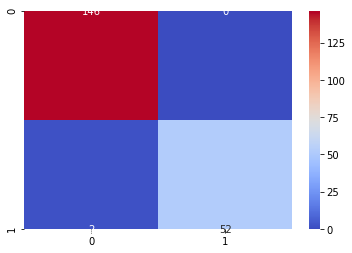

In [38]:
sns.heatmap(confusion_matrix(data.is_ethics, y_pred), annot=True, fmt="d", cmap="coolwarm")

In [42]:
confidence_margin = 0.33

print(sum(np.logical_or(y_prob[:,1]<confidence_margin, y_prob[:,1]>1-confidence_margin)))
print(sum(y_prob[:,1]>1-confidence_margin))

176
39


In [43]:
data_full = pd.read_csv("cyai-full.tsv", sep="\t")

In [69]:
data_full

,fname,date,is_ai,is_ethics,title,description,is_ai %,is_ethics %,a_is_ai,l_is_ai,p_is_ai,a_is_ethics,l_is_ethics,p_is_ethics,clf_is_ai,clf_is_ai_prob,clf_is_ethics,clf_is_ethics_prob
0,abs1705.03487,2017-05-06,1.0,0.0,A neural network system for transformation of ...,We propose a novel system which can transform ...,100.00%,0.00%,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,abs1910.02390,2019-10-06,1.0,0.0,Migration through Machine Learning Lens -- Pre...,"In this paper, we have discussed initial findi...",100.00%,33.33%,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
2,abs1405.1605,2014-05-07,1.0,0.0,DepecheMood: a Lexicon for Emotion Analysis fr...,While many lexica annotated with words polarit...,100.00%,33.33%,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
3,abs1907.04534,2019-07-10,1.0,1.0,The Role of Cooperation in Responsible AI Deve...,"In this paper, we argue that competitive press...",100.00%,100.00%,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,abs1906.04272,2019-06-10,1.0,1.0,Building High-Quality Auction Fraud Dataset,Given the magnitude of online auction transact...,100.00%,66.67%,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN
5,abs1707.06939,2017-07-21,1.0,0.0,Autocompletion interfaces make crowd workers s...,Creative tasks such as ideation or question pr...,100.00%,0.00%,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6,abs1810.02724,2018-10-02,1.0,1.0,Human Indignity: From Legal AI Personhood to S...,It is possible to rely on current corporate la...,100.00%,100.00%,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
7,abs1904.05643,2019-04-11,1.0,0.0,Political Discussions in Homogeneous and Cross...,"Online platforms, such as Facebook, Twitter, a...",66.67%,33.33%,1.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
8,abs1903.02706,2019-03-06,1.0,0.0,Twitter Speaks: A Case of National Disaster Si...,"In recent years, we have been faced with a ser...",66.67%,33.33%,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
9,abs0901.3839,2009-01-24,1.0,0.0,Remembering what we like: Toward an agent-base...,Analysis of aggregate Web traffic has shown th...,66.67%,0.00%,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [45]:
docs_full = []
for doc in nlp.pipe(data_full.description):
    docs_full.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [47]:
X_full = vectorizer.transform(docs_full)

In [50]:
y_full_pred = pipeline.predict(X_full)
y_full_prob = pipeline.predict_proba(X_full)

In [70]:
data_full["clf_is_ethics"] = y_full_pred
data_full["clf_is_ethics_prob"] = y_full_prob[:,1]

In [71]:
data_full

,fname,date,is_ai,is_ethics,title,description,is_ai %,is_ethics %,a_is_ai,l_is_ai,p_is_ai,a_is_ethics,l_is_ethics,p_is_ethics,clf_is_ai,clf_is_ai_prob,clf_is_ethics,clf_is_ethics_prob
0,abs1705.03487,2017-05-06,1.0,0.0,A neural network system for transformation of ...,We propose a novel system which can transform ...,100.00%,0.00%,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0,0.290394
1,abs1910.02390,2019-10-06,1.0,0.0,Migration through Machine Learning Lens -- Pre...,"In this paper, we have discussed initial findi...",100.00%,33.33%,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,0,0.293560
2,abs1405.1605,2014-05-07,1.0,0.0,DepecheMood: a Lexicon for Emotion Analysis fr...,While many lexica annotated with words polarit...,100.00%,33.33%,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,0,0.255565
3,abs1907.04534,2019-07-10,1.0,1.0,The Role of Cooperation in Responsible AI Deve...,"In this paper, we argue that competitive press...",100.00%,100.00%,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1,0.780997
4,abs1906.04272,2019-06-10,1.0,1.0,Building High-Quality Auction Fraud Dataset,Given the magnitude of online auction transact...,100.00%,66.67%,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,1,0.751128
5,abs1707.06939,2017-07-21,1.0,0.0,Autocompletion interfaces make crowd workers s...,Creative tasks such as ideation or question pr...,100.00%,0.00%,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0,0.255658
6,abs1810.02724,2018-10-02,1.0,1.0,Human Indignity: From Legal AI Personhood to S...,It is possible to rely on current corporate la...,100.00%,100.00%,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1,0.704860
7,abs1904.05643,2019-04-11,1.0,0.0,Political Discussions in Homogeneous and Cross...,"Online platforms, such as Facebook, Twitter, a...",66.67%,33.33%,1.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,0,0.319428
8,abs1903.02706,2019-03-06,1.0,0.0,Twitter Speaks: A Case of National Disaster Si...,"In recent years, we have been faced with a ser...",66.67%,33.33%,1.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,0,0.242234
9,abs0901.3839,2009-01-24,1.0,0.0,Remembering what we like: Toward an agent-base...,Analysis of aggregate Web traffic has shown th...,66.67%,0.00%,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0.293575


In [73]:
data_full.to_csv('cyai-clf.tsv',sep='\t',index=False,header=True, quoting=csv.QUOTE_NONE)

In [76]:
dump(pipeline, "imba_pipeline.joblib")

['imba_pipeline.joblib']